In [1]:
import meep as mp
import math
import cmath
import argparse
import numpy as np
from IPython.display import Video
import matplotlib.pyplot as plt

Using MPI version 3.1, 1 processes


## Define materials

In [2]:
# epsilon from supplementary material of ilic et al for lambda = 610 nm, values confirmed on the site https://refractiveindex.info/

n_SiO2 = 1.46
n_Al2O3 = 1.68
n_Ta2O5 = 2.09
n_TiO2 = 2.35
SiO2 = mp.Medium(epsilon=n_SiO2**2)
Al2O3 = mp.Medium(epsilon=n_Al2O3**2)
Ta2O5 = mp.Medium(epsilon=n_Ta2O5**2)
TiO2 = mp.Medium(epsilon=n_TiO2**2)

## Set up quarter-wave (qw) stack parameters

In [3]:
# design qw stack to block wavelength of lambda_0 microns
lambda_0 = 1.2
fcen_0 = 1/lambda_0
print('Center frequency', fcen_0)

# set up qw stack
n_layers = 10
n1 = n_SiO2
n2 = n_TiO2
material1 = SiO2
material2 = TiO2
a = (n1+n2)/(4*n1*n2*fcen_0)
d1 = a*n2/(n1+n2)
d2 = a*n1/(n1+n2)

# Compute qw stack delta f
delta_f = fcen_0*(4/np.pi)*np.arcsin(np.abs(n1-n2)/(n1+n2))
print('Quarter wave gap size', delta_f)

Center frequency 0.8333333333333334
Quarter wave gap size 0.25016415689653043


## Spectral reflectance and transmittance at normal incidence for quarter-wave stack of SiO2 and TiO2 

-----------
Initializing structure...
time for choose_chunkdivision = 0.000298977 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
time for set_epsilon = 0.224069 s
-----------


<AxesSubplot:xlabel='X', ylabel='Y'>

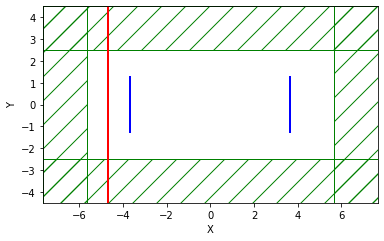

In [4]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml)]

# pad up structure and make cell
pad = 4.
y_length = 5.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make geometry, no qw stack
geometry = []


# make a line of sources corresponding to normal incidence
# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml + pad/4
sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy)) ]

# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=mp.Vector3())

# set up fluxes for reflected and transmitted flux
nfreq = 100
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, y_length/2))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,y_length/2,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Plot
sim.plot2D()

In [5]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

on time step 3118 (time=38.975), 0.00128295 s/step
field decay(t = 50.0125): 0.09987548842241936 / 0.09987548842241936 = 1.0
on time step 6198 (time=77.475), 0.00129882 s/step
field decay(t = 100.025): 0.2460356599098966 / 0.2460356599098966 = 1.0
on time step 9220 (time=115.25), 0.00132363 s/step
field decay(t = 150.0375): 1.4238074362198705e-08 / 0.2460356599098966 = 5.786996229494938e-08
run 0 finished at t = 150.0375 (12003 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 0.000375032 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

<AxesSubplot:xlabel='X', ylabel='Y'>

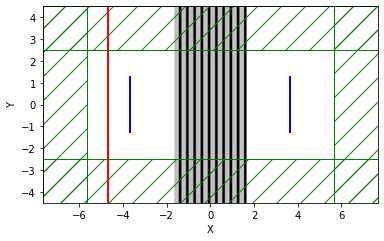

In [6]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=mp.Vector3())

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)

# plot
sim.plot2D()

In [7]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

on time step 2996 (time=37.45), 0.00133525 s/step
field decay(t = 50.0125): 0.028789998691846633 / 0.028789998691846633 = 1.0
on time step 6026 (time=75.325), 0.00132051 s/step
field decay(t = 100.025): 0.10457806760557067 / 0.10457806760557067 = 1.0
on time step 9046 (time=113.075), 0.00132462 s/step
field decay(t = 150.0375): 6.246886539128096e-09 / 0.10457806760557067 = 5.973419362355225e-08
run 0 finished at t = 150.0375 (12003 timesteps)


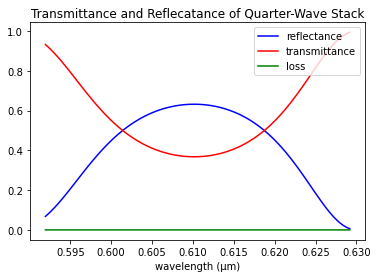

In [8]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-qw_refl_flux[i]/norm_tran_flux[i])
    Ts = np.append(Ts,qw_tran_flux[i]/norm_tran_flux[i])    
plt.figure()
plt.plot(wl,Rs,'b',label='reflectance')
plt.plot(wl,Ts,'r',label='transmittance')
plt.plot(wl,1-Rs-Ts,'g',label='loss')
plt.title('Transmittance and Reflecatance of Quarter-Wave Stack')
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000368118 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

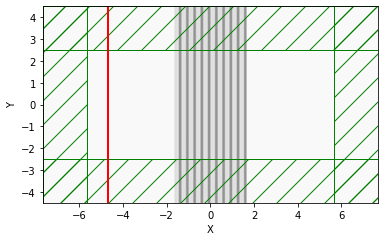

In [9]:
# Make Animation

animate = mp.Animate2D(sim, fields=mp.Ez, normalize=True)
sim.reset_meep()
sim.run(mp.at_every(1,animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))

In [10]:
# Play animation

filename = "qw_stack.mp4"
fps = 10
animate.to_mp4(fps,filename)
Video(filename)

Generating MP4...


## Angular and spectral reflectance and transmittance of quarter-wave stack

### Start with just one angle

In [11]:
# Define source at an angle

# send in light centered at 610 nm wavelgnth
lambda_cen = 0.61
fcen = 1/lambda_cen
df = 0.1
src_pos = -0.5*sx + dpml #+ pad/4
src_pt = mp.Vector3(src_pos, 0)

# Set theta incidence, compute k and the amplitude function
theta_in = np.pi/6
n0 = 1. # air
k = mp.Vector3(fcen*n0).rotate(mp.Vector3(z=1), theta_in)
def pw_amp(k,x0):
    def _pw_amp(x):
        return cmath.exp(1j*2*math.pi*k.dot(x+x0))
    return _pw_amp

sources = [ mp.Source(mp.GaussianSource(fcen, fwidth=df, is_integrated=True),
                      # need is_integrated=True because source extends through pml
                      component=mp.Ez, 
                      center=mp.Vector3(src_pos,0),
                      size=mp.Vector3(0, sy), 
                      amp_func=pw_amp(k,src_pt)) ]

In [12]:
k

Vector3<1.4197137766958012, 0.8196721311475409, 0.0>

-----------
Initializing structure...
time for choose_chunkdivision = 6.41346e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
time for set_epsilon = 0.224158 s
-----------
Meep: using complex fields.


<AxesSubplot:xlabel='X', ylabel='Y'>

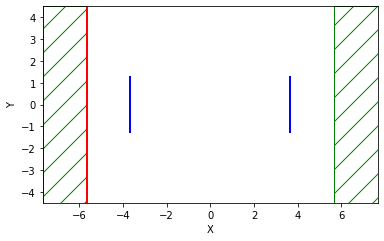

In [13]:
# Set up simulation for first run: no qw stack

resolution = 40     # pixels/um

# set pml
dpml = 2.
pml_layers = [mp.PML(dpml, direction=mp.X)]

# pad up structure and make cell
pad = 4.
y_length = 5.
sx = n_layers*a + 2*dpml + 2*pad
sy = y_length + 2*dpml
cell = mp.Vector3(sx,sy)

# make geometry, no qw stack
geometry = []




# make simulation object
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# set up fluxes for reflected and transmitted flux
nfreq = 100
refl_pos = -0.5*sx + dpml + pad/2
refl_fr = mp.FluxRegion(center=mp.Vector3(refl_pos,0), size=mp.Vector3(0, y_length/2))
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran_pos = 0.5*sx - dpml - pad/2
tran_fr = mp.FluxRegion(center=mp.Vector3(tran_pos,0), size=mp.Vector3(0,y_length/2,0))
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Plot
sim.plot2D()

In [14]:
# Normalization run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
norm_refl_data = sim.get_flux_data(refl)
norm_tran_flux = mp.get_fluxes(tran)

on time step 1982 (time=24.775), 0.00201851 s/step
on time step 3980 (time=49.75), 0.00200252 s/step
field decay(t = 50.0125): 0.0795574460017068 / 0.0795574460017068 = 1.0
on time step 5983 (time=74.7875), 0.00199785 s/step
on time step 7975 (time=99.6875), 0.00200892 s/step
field decay(t = 100.025): 0.3331643631258154 / 0.3331643631258154 = 1.0
on time step 9984 (time=124.8), 0.00199188 s/step
on time step 11971 (time=149.638), 0.00201375 s/step
field decay(t = 150.0375): 1.7033054509435593e-07 / 0.3331643631258154 = 5.112507937412043e-07
run 0 finished at t = 150.0375 (12003 timesteps)


-----------
Initializing structure...
time for choose_chunkdivision = 9.58443e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

<AxesSubplot:xlabel='X', ylabel='Y'>

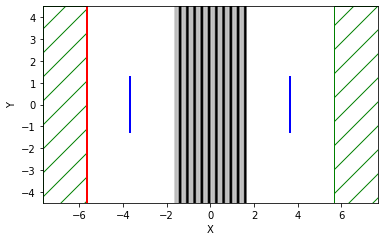

In [15]:
# Set up second simulation, with quarter-wave stack

sim.reset_meep()

geometry = [mp.Block(mp.Vector3(d1, mp.inf),
                     center=mp.Vector3(d1/2 + i*a, 0),
                     material=material1) for i in range(-n_layers//2, n_layers//2)] + \
            [mp.Block(mp.Vector3(d2, mp.inf),
                     center=mp.Vector3(d1 + d2/2 + i*a, 0),
                     material=material2) for i in range(-n_layers//2, n_layers//2)]

sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution,
                    k_point=k)

# Make new fluxes
refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Load negated fields from normalization run
sim.load_minus_flux_data(refl, norm_refl_data)

# plot
sim.plot2D()

In [16]:
# Second run

pt = mp.Vector3(0.5*sx-dpml-pad/4, 0)
sim.run(until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))
qw_refl_flux = mp.get_fluxes(refl)
qw_tran_flux = mp.get_fluxes(tran)

flux_freqs = mp.get_flux_freqs(refl)

on time step 1905 (time=23.8125), 0.00209982 s/step
on time step 3795 (time=47.4375), 0.00211724 s/step
field decay(t = 50.0125): 0.027508371286845138 / 0.027508371286845138 = 1.0
on time step 5706 (time=71.325), 0.00209412 s/step
on time step 7614 (time=95.175), 0.00209719 s/step
field decay(t = 100.025): 0.2436239079920468 / 0.2436239079920468 = 1.0
on time step 9510 (time=118.875), 0.00211052 s/step
on time step 11426 (time=142.825), 0.00208785 s/step
field decay(t = 150.0375): 8.006017907890862e-05 / 0.2436239079920468 = 0.00032862201308059725
on time step 13322 (time=166.525), 0.00211041 s/step
on time step 15239 (time=190.488), 0.00208702 s/step
field decay(t = 200.05): 6.437617215787e-11 / 0.2436239079920468 = 2.642440665551247e-10
run 0 finished at t = 200.05 (16004 timesteps)


In [ ]:
flux_freqs

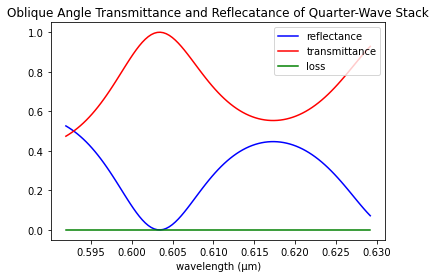

In [17]:
wl = []
Rs = []
Ts = []
for i in range(nfreq):
    wl = np.append(wl, 1/flux_freqs[i])
    Rs = np.append(Rs,-qw_refl_flux[i]/norm_tran_flux[i])
    Ts = np.append(Ts,qw_tran_flux[i]/norm_tran_flux[i])    
plt.figure()
plt.plot(wl,Rs,'b',label='reflectance')
plt.plot(wl,Ts,'r',label='transmittance')
plt.plot(wl,1-Rs-Ts,'g',label='loss')
plt.title('Oblique Angle Transmittance and Reflecatance of Quarter-Wave Stack')
plt.xlabel("wavelength (μm)")
plt.legend(loc="upper right")
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 9.29832e-05 s
Working in 2D dimensions.
Computational cell is 15.325 x 9 x 0 with resolution 40
     block, center = (-1.56296,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-1.22982,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.896677,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.563538,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1316,2.1316,2.1316)
     block, center = (-0.230399,0,0)
          size (0.205479,1e+20,0)
          axes (1,0,0), (0,1,

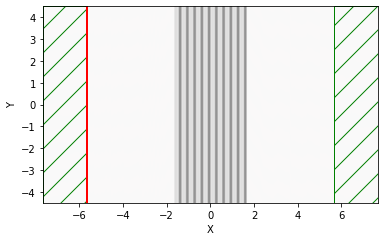

In [18]:
# Make Animation

animate = mp.Animate2D(sim, fields=mp.Ez, normalize=True)
sim.reset_meep()
sim.run(mp.at_every(1,animate),until_after_sources=mp.stop_when_fields_decayed(50,mp.Ez, pt, 1e-6))

In [19]:
# Play Animation

filename = "qw_angle.mp4"
fps = 10
animate.to_mp4(fps,filename)
Video(filename)

Generating MP4...
